<a href="https://colab.research.google.com/github/kalebmes/CS376-Machine-Learning/blob/main/Homeworks/CS376_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# CS376 HW3: RNN, LSTM, Attention ***(Total score: 60)***

(Note that this score is not the same score that will be used in computing your final HW grade. The score will be re-scaled considering other homeworks.)

In this assignment, you will implement neural machine translation (NMT) models using:

1. RNNs
2. LSTMs and LSTMs with attention

As in the previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook (except for Discuss/Analysis section). You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.

---

**1. How to submit**
* Submit **one** files to KLMS (You don't need to submit pdf file anymore):
  - hw3_{student_ID}.ipynb, 

**2. Note**
*   **Both ipynb and PDF files must contain executed log of all code blocks (after the last execution).**
*   Your code should be reproducible. If we cannot reproduce, you will get penalty so please make sure everything works well before you submit.
*   You are required to use the functions given in the notebook, do not use more advanced methods.


**3. Grading**
* Total score is **60pt**.
* Code (25pt) -  We will check whether you implemented your codes correctly and it can reproduce the results you made.
* Evaluation (25pt) - You can get the evalutation score whenever you pass the test cell.
* Discussion (10pt) - It will be given if you experiment deeply enough with different condition and provide your reasonable explanation.

---

###**Change log**###

2022.04.28)  
  LSTM Encoder-Decoder:   LSTM encoder prediction -> LSTM decoder prediction


2022.05.02)  
  Test cell for TODO1,2: Annotation added. Minor code fix.

2022.05.09)  
  MLPAttention: Notation fixes. (vector v -> h)

In [1]:
# Before start, fill your information and run it.

NAME = "Kaleb Mesfin Asfaw"
STUDENT_ID = "20200805"
asgn3_score = 0

## Setup

First let's import some libraries that will be useful in this assignment.


In [2]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

def seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

Make sure you are using the GPU.

In [3]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  
device = torch.device('cuda:0')

Good to go!


For this assignment, we will use an English-to-French dataset. As shown below, the dataset contains multiple lines each of which has an English sentence and its French translation separated by a tab. In this problem, since English is translated to French, English is the source language and French is the target language. Note that each text sequence is of variable lengnth and can be just one sentence or a paragraph of multiple sentences.

In [4]:
def download_if_not_exist(file_name):
  
  if not os.path.exists(file_name):
    import urllib.request
    DATA_URL = 'https://download.pytorch.org/tutorial/data.zip'

    file_name, _ = urllib.request.urlretrieve(DATA_URL, './data.zip')
    
  return file_name

def read_raw(file_name):
  file_name = download_if_not_exist(file_name)
  
  with zipfile.ZipFile(file_name, 'r') as fzip:
    raw_text = fzip.read(file_name.split('.')[-2][1:] + '/eng-fra.txt').decode('utf-8')
  return raw_text

In [5]:
raw_text = read_raw('./data.zip')
print(raw_text[:200])

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
I see.	Je comprends.


Next we'll do some preprocessing on this raw text. We need to replace special symbols (non-breaking spaces) with spaces, convert all characters to lower case, and insert a space between words and punctuation marks.

In [6]:
def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
      out += ' '
    out += char
  return out

We further split the source-target pairs into a source list and a target list. We use word-level tokenization here. 

In [7]:
def split_source_target(text, max_len):
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if i > 5000: # we only use 5000 pairs of translation
      break
    parts = line.split('\t')
    if len(parts) == 2:
      src_tokens = parts[0].split(' ')
      tgt_tokens = parts[1].split(' ')
      if (len(src_tokens) <= max_len) and (len(tgt_tokens) <= max_len):
        source.append(src_tokens)
        target.append(tgt_tokens)
  return source, target

In [8]:
def prepare_data(raw_text, max_len=10000):
  text = preprocess_raw(raw_text)
  source, target = split_source_target(text, max_len)
  return source, target

source, target = prepare_data(raw_text)

Using the whole dataset takes too much memory, and it is hard to train with a large vocabulary. Thus, we will filter out some words by looking at the statistical properties of the dataset.

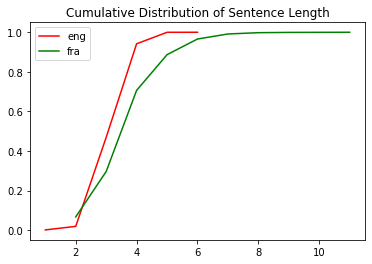

In [9]:
def len_dis(text):
  lens = [len(line) for line in text]
  len_counter = collections.Counter(lens)

  lens = np.array(list(len_counter.keys()))
  sort_idx = np.argsort(lens)
  lens_sort = lens[sort_idx]
  len_counts = np.array(list(len_counter.values()))
  len_counts_sort = len_counts[sort_idx]
  p = np.cumsum(len_counts_sort) / len_counts_sort.sum()
  return p, lens_sort
  
src_p, src_lens_sort = len_dis(source)
tgt_p, tgt_lens_sort = len_dis(target)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.plot(tgt_lens_sort, tgt_p, 'g-', label='fra')
plt.title('Cumulative Distribution of Sentence Length')
plt.legend()
plt.show()

From the above plots, we can see that more than 90% of the sentences have a length of less than 8. Thus, we can filter out sentences of length greater than 8. We also filter out words that occur less than 5 times in the corpus.

In [10]:
# hyper-param
MAX_LEN = 8
MIN_FREQ = 5

### Build Vocabulary

Each word needs a unique index, and the words that have been filtered out need a special token to represent them. The following class Vocab is used to build the vocabulary. Some basic helper functions or dictionaries are also provided:
- Dictionary word2index: Convert word string into index: 
- Dictionary index2word: Convert index into word string
- helper function _build_vocab(): Build dictionaries for converting from words to indices and vice versa
- Word Counter, num_word: Record the total number of unique tokens in the vocabulary 
    
There are 4 special tokens added in the vocabulary:
- 'pad': padding token. Sentences shorter than MAX_LEN is padded by this symbol to make the length to MAX_LEN
- 'bos': beginning of sentence. This indicates the beginning of a sentence
- 'eos': end of sentence. This indicates the end of a sentence
- 'unk': unknown word. This represents words that have been filtered out (words that are not in the vocabulary)

In [11]:
class Vocab():
  def __init__(self, name, tokens, min_freq):
    self.name = name
    self.index2word = {
      0: 'pad',
      1: 'bos',
      2: 'eos',
      3: 'unk'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.num_word = 4
    token_freq = collections.Counter(tokens)
    tokens = [token for token in tokens if token_freq[token] >= MIN_FREQ]
    self._build_vocab(tokens)
    
  def _build_vocab(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.num_word
        self.index2word[self.num_word] = token
        self.num_word += 1
        
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

### Build Dataset

The dataset pipeline involves the following steps:
- For target language, every sentence will be 'sandwiched' with the 'bos' token and the 'eos' token.
- Every sentence that has a length less than MAX_LEN will be padded to the MAX_LEN with the *padding_token*.
- The dataset should return the converted tensor and the corresponding valid length before padding.
- We use the Pytorch *DataLoader* API to build the dataset generator.

For the purposes of this assignment, we will train and evaluate on only the training data. This isn't ideal because we do not know if we are  overfitting to the training data, but it is fine for instructional purposes. In practice (eg. for your projects), you should make sure to split your data into training/validation/test datasets.

In [12]:
def build_vocab(name, tokens, min_freq):
  tokens = [token for line in tokens for token in line]
  return Vocab(name, tokens, min_freq)

def build_vocabs(lang_src, lang_tgt, src_text, tgt_text):
  vocab_src = build_vocab(lang_src, src_text, MIN_FREQ)
  vocab_tgt = build_vocab(lang_tgt, tgt_text, MIN_FREQ)
  return vocab_src, vocab_tgt

def pad(line, padding_token):
  return line + [padding_token] * (MAX_LEN + 2 - len(line))

def build_tensor(text, lang, is_source):
  lines = [lang[line] for line in text]
  if not is_source:
    lines = [[lang['bos']] + line + [lang['eos']] for line in lines]
  array = torch.tensor([pad(line, lang['pad']) for line in lines])
  valid_len = (array != lang['pad']).sum(1)
  return array, valid_len

def load_data_nmt(batch_size=2):
  lang_eng, lang_fra = build_vocabs('eng', 'fra', source, target)
  src_array, src_valid_len = build_tensor(source, lang_eng, True)
  tgt_array, tgt_valid_len = build_tensor(target, lang_fra, False)
  train_data = torch.utils.data.TensorDataset(
    src_array, src_valid_len, tgt_array, tgt_valid_len)
  print(train_data[0])
  train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
  return lang_eng, lang_fra, train_iter


source, target = prepare_data(raw_text, max_len=MAX_LEN)
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size=2)
print('Vocabulary size of source language: {}'.format(vocab_eng.num_word))
print('Vocabulary size of target language: {}'.format(vocab_fra.num_word))
print('Total number of sentence pairs: {}'.format(len(source)))

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
Vocabulary size of source language: 433
Vocabulary size of target language: 420
Total number of sentence pairs: 4990


## Sequence to Sequence with RNN (baseline)

In this section, we provide the implementation of the seq2seq RNN baseline model. You do not need to implement any code in this section, but you should read and understand what the code is doing because you will need to implement something similar in subsequent sections. The following figure highlights the architecture of the seq2seq model. An encoder RNN encodes the input sequence into its hidden state, and passes the last hidden state to the decoder RNN. The decoder generates the target sequence.

Implementation Details:

- Embedding: We have represented each word with an integer or one-hot vector. We need an embedding layer to map an input word to its embedding vector.
- Encoder: A vanilla RNN is used to encode a source sequence. The final hidden state is returned as output and passed to the decoder RNN.
- Decoder: Another vanilla RNN is implemented to generate the target sequence. The hidden state is initialized with the last hidden state from the encoder.
- Encoder-Decoder: The class NMTRNN is built by combining the encoder and the decoder, and yields the loss and predictions.
- Loss: We have padded all sentences so that they have the same MAX_LEN. Thus, when we compute the loss, the loss from those padding_tokens should be masked out.

<div>
<img src="https://raw.githubusercontent.com/dsgiitr/d2l-pytorch/24e89824c154c2afc419c5dadec9622e490b99bb/img/seq2seq.svg" width="600"/>
</div>
Image source: https://github.com/dsgiitr/d2l-pytorch/blob/master/img/seq2seq.svg

In [13]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Encoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding layer
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.hidden_size = hidden_size
    
  def forward(self, sources, valid_len):
    """
    Inputs:
      source: tensor of size (N, T), where N is the batch size, T is the length of the sequence(s)
      valid_len: tensor of size (N,), indicating the valid length of sequence(s) (the length before padding)
    """
    word_embedded = self.embedding(sources)

    N = word_embedded.shape[0]
    
    h = sources.new_zeros(1, N, self.hidden_size).float() # initialize hidden state with zeros
    
    o, h = self.enc(word_embedded, h)
    
    return o[np.arange(N), valid_len] # return the hidden state of the valid last time step

class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size
    
  def forward(self, h, target):
    word_embedded = self.embedding(target)
    N, T = word_embedded.shape[:2]
    o, h = self.enc(word_embedded, h.view(1,N,self.hidden_size))
    pred = self.output_emb(o)
    return pred, h

class NMTRNN(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size):
    super(NMTRNN, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size)
    
  def forward(self, src, src_len, tgt, tgt_len):
    h = self.enc(src, src_len)
    T = tgt.shape[1]
    pred, _ = self.dec(h, tgt)
       
    loss = F.nll_loss(F.log_softmax(pred[:, :T-1].transpose(1,2), dim = 1), tgt[:, 1:], ignore_index=0, reduction = 'none')
    loss = loss.sum(1).mean()

    return loss, pred.argmax(dim=-1)

  def predict(self, src, src_len, tgt, tgt_len):
      """
      When predicting a sequence given the 'bos' token, the input for the next step is the predicted
      token from the previous time step.
      """
      h = self.enc(src, src_len)
      
      inputs = tgt[:, :1]
      preds = []
      for t in range(MAX_LEN+1): # plus the 'eos' token
        pred, h = self.dec(h, inputs)
        preds.append(pred)
        inputs = pred.argmax(dim=-1)
        
      pred = torch.cat(preds, dim=1).argmax(dim=-1)
      return pred
        

In [14]:
def train_rnn(net, train_iter, lr, epochs, device):
  # training
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)
      
      loss_list.append(loss.mean().detach())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))
  return loss_list

seed(1)
batch_size = 32
lr = 1e-3
epochs = 50

embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
rnn_net = NMTRNN(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size)

rnn_loss_list = train_rnn(rnn_net, train_iter, lr, epochs, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7800	Loss:	30.051929
pred:	 tensor([146,  65, 349,  53,   3, 330,  52, 330, 330, 330])

tgt:	 tensor([ 3, 11,  2,  0,  0,  0,  0,  0,  0])

iter 156 / 7800	Loss:	10.511122
pred:	 tensor([14,  3,  3, 11,  2, 11,  3,  3,  3,  3])

tgt:	 tensor([15, 89,  3, 11,  2,  0,  0,  0,  0])

iter 312 / 7800	Loss:	9.733450
pred:	 tensor([  3, 164,   3,  11,  11,   2,  11,   3,   3,   3])

tgt:	 tensor([ 48,  49, 113, 282,  11,   2,   0,   0,   0])

iter 468 / 7800	Loss:	8.342284
pred:	 tensor([ 3,  3,  5,  3, 11,  2, 11,  3,  3,  3])

tgt:	 tensor([36,  3, 37,  3,  5,  2,  0,  0,  0])

iter 624 / 7800	Loss:	6.555187
pred:	 tensor([36,  3,  3, 11,  2,  5,  3,  3,  3,  3])

tgt:	 tensor([36,  9, 88, 11,  2,  0,  0,  0,  0])

iter 780 / 7800	Loss:	6.749533
pred:	 tensor([14, 28,  3, 11,  2, 11,  3,  3,  3,  3])

tgt:	 tensor([14, 28,  3, 11,  2,  0,  0,  0,  0])

iter 936 / 7800	Loss:	7.1045

### RNN Loss Curve

Plot the loss curve over time.

Text(0.5, 1.0, 'Loss Curve of Baseline')

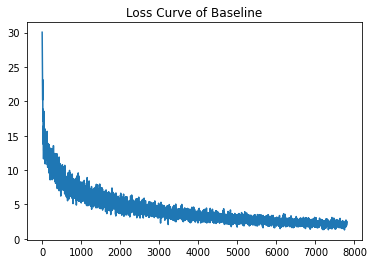

In [15]:
# save the loss curve figure in a file for the report
rnn_loss_list = torch.tensor(rnn_loss_list, device = 'cpu')
plt.plot(np.arange(len(rnn_loss_list)), rnn_loss_list)
plt.title('Loss Curve of Baseline')

### Prediction Accuracy

Print out 5 prediction samples, and calculate the prediction accuracy over the training dataset. You will see an accuracy of over 70%.

In [16]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_rnn(net, train_iter, device):
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]

    pred = net.predict(*train_data)

    pred_acc = comp_acc(pred.detach().cpu(), train_data[2].detach().cpu()[:, 1:], train_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()] 
        if pred_wd == 'eos':
          break
          
        pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].cpu()]))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  
seed(1)
batch_size = 32

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)

evaluate_rnn(rnn_net, train_iter, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
pred:	 ['entrez', '!']

tgt:	 ['unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'unk', 'vu', '.']

tgt:	 ['je', "t'en", 'dois', 'une', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['est-il', 'grand', '?']

tgt:	 ['est-il', 'unk', '?', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'suis', 'unk', '.']

tgt:	 ['je', 'suis', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['unk', 'à', 'qui', 'que', 'ce', 'soit', '!']

tgt:	 ['demande', 'à', 'unk', 'qui', '!', 'eos', 'pad', 'pad', 'pad']

Prediction Acc.: 0.7096


## Sequence to Sequence with LSTM and Attention

Now let's try to improve our model by using an LSTM and the attention mechanism.


### LSTM

LSTMs eliminate the gradient explosion/vanishing problem. Its state and gate update at each time step can be summarized as follows:

$$
\begin{align*}
&\text{State Update} &&& C_t &= F_t \odot C_{t-1} + I_t \odot \tilde{C}_t \\
&\text{Hidden States} &&& H_t &= O_t \odot \text{tanh}(C_t) \\
&\text{Proposal} &&& \tilde{C}_t &= \text{tanh}( X_tW_{xc} + H_{t-1}W_{hc} + b_c ) \\
&\text{Input Gate} &&& I_t &= \sigma( X_tW_{xi} + H_{t-1}W_{hi} + b_i ) \\
&\text{Forget Gate} &&& F_t &= \sigma( X_tW_{xf} + H_{t-1}W_{hf} + b_f ) \\
&\text{Output Gate} &&& O_t &= \sigma( X_tW_{xo} + H_{t-1}W_{ho} + b_o ) \\
\end{align*}
$$

Implement the LSTM class below. In particular,
-  Complete the initialization function *init_params()*. Weights should be initialized using `torch.randn` multiplied with a scale of 0.1. Biases should be initialized to 0.
- Complete the function *lstm()* which performs the feed-forward pass of LSTM. **Do not** use `nn.LSTM` or `nn.LSTMCell` in your implementation.

In [17]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, device):
    super(LSTM, self).__init__()
    self.device = device
    self.params = nn.ParameterList(self.init_params(input_size, hidden_size))
    """
    Inputs:
      input_size: int, feature dimension of input sequence
      hidden_size: int, feature dimension of hidden state
      device: torch.device()
    """
  
  def init_params(self, input_size, hidden_size):
    """
    Inputs:
      input_size: int, feature dimension of input sequence
      hidden_size: int, feature dimension of hidden state
      
    Outputs:
      Weights for proposal: W_xc, W_hc, b_c
      Weights for input gate: W_xi, W_hi, b_i
      Weights for forget gate: W_xf, W_hf, b_f
      Weights for output gate: W_xo, W_ho, b_o
    """
    W_xc, W_hc, b_c = None, None, None
    W_xi, W_hi, b_i = None, None, None
    W_xf, W_hf, b_f = None, None, None
    W_xo, W_ho, b_o = None, None, None
    ##############################################################################
    # TODO1: Initialize the weights and biases. The result will be stored in 
    # `params` below. Weights should be initialized using `torch.randn` multiplied 
    # with the scale (0.1). Biases should be initialized to 0.
    ##############################################################################
    # Replace "pass" statement with your code
    W_xc, W_hc, b_c = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
    W_xi, W_hi, b_i = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
    W_xf, W_hf, b_f = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
    W_xo, W_ho, b_o = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
  
    # END OF YOUR CODE
    
    params = [W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o]
    return params

  
  def lstm(self, X, state):
    """
    Inputs:
      X: tuple of tensors (src, src_len). src, size (N, D_in) or (N, T, D_in), where N is the batch size,
        T is the length of the sequence(s), D_in is the input size. src_len, size of (N,), is
        the valid length for each sequence.
        
      state: tuple of tensors (h, c). h, size of (N, hidden_size) is the hidden state of LSTM. c, size of 
            (N, hidden_size), is the memory cell of the LSTM.
      
    Outputs:
      o: tensor of size (N, T, hidden_size). Contains the output features (the hidden state H_t) for each t.
      state: the same as input state. Contains the hidden state H_T and cell state C_T for the last timestep T.
    """
    
    src, src_len = X
    h, c = state

    # make sure always has a T dim
    if len(src.shape) == 2:
      src = src.unsqueeze(1)

    N, T, D_in = src.shape
    W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o = self.params
    o = []
    ##############################################################################
    # TODO2: Implement the forward pass of the LSTM. LSTM must not be updated by
    # unvalid inputs. In other words, you should update LSTM only when
    # valid words come in. (use src_len)
    ##############################################################################
    # Replace "pass" statement with your code
    hidden_size = h.shape[1]
    o = torch.zeros((N, T, hidden_size), device=self.device)
    for t in range(T):
      x_t = src[:, t, :] # (N, D_in)
      iden = torch.tensor([t] * N, device=self.device) - src_len.to(device)
      iden[iden < 0] = -1
      if -1 in iden:  
        i_t = torch.sigmoid(x_t @ W_xi + h @ W_hi + b_i)
        f_t = torch.sigmoid(x_t @ W_xf + h @ W_hf + b_f)
        o_t = torch.sigmoid(x_t @ W_xo + h @ W_ho + b_o)
        c_til = torch.tanh(x_t @ W_xc + h @ W_hc + b_c)
        c = f_t * c + i_t * c_til
        h = o_t * torch.tanh(c)
      o[:, t, :] = h
    
    # END OF YOUR CODE

    state = (h, c)
    return o, state
  
  def forward(self, inputs, state):
    return self.lstm(inputs, state)

Check that your output has the correct shape. You should see:

```
torch.Size([12, 8, 5])
torch.Size([12, 5])
torch.Size([12, 5])
```

In [18]:
test_lstm = LSTM(10, 5, torch.device('cuda:0'))
test_src = torch.ones(12, 8, 10)
test_src[:,7] = 0
test_src_len = torch.ones(12) * 7
test_h = torch.zeros(12, 5).float()
test_c = torch.zeros(12, 5).float()

test_o, test_state = test_lstm((test_src, test_src_len), (test_h, test_c))

print(test_o.shape)
print(test_state[0].shape)
print(test_state[1].shape)

# must not be updated for the last element in this test case.
if (test_o.shape == (12,8,5) and test_state[0].shape == (12,5) and test_state[1].shape == (12,5) and torch.equal(test_o[:,6], test_o[:,7])):
  print("Correct")
  LSTM_score = 5

else:
  print("Wrong")
  LSTM_score = 0

torch.Size([12, 8, 5])
torch.Size([12, 5])
torch.Size([12, 5])
Correct


### Attention Mechanism

Another improvement we can make to our model is the Attention Mechanism. An example illustrating why applying attention mechanisms can improve the performance is shown in the picture below. An English sentence and its Chinese is visualized and aligned into blue boxes and red boxes, respectively. It can be seen that the Chinese character '她' has a long distance from its English counterpart, 'she'. Since only the final hidden state is passed to the decoder, it's hard for the baseline model to 'attend' to information a long time ago.

<div>
<img src="https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png" width="600"/>
</div>
Image source: https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png

- **Attention**

    Given a query, $\mathbf{q} \in R^{d_q}$, and a set of $N$ (key, value) pairs, $\{ \mathbf{k}_i, \mathbf{v}_i\}^N$ where $k_i \in R^{d_k}$ and $v_i \in R^{d_v}$, the attention mechanism computes a weighted sum of values based on the normalized score obtained from the query and each key:
    
    \begin{align*}
    a_i &= \alpha(\mathbf{q}, \mathbf{k_i}) \\
    \mathbf{a} &= [a_1, ..., a_n] \\
    \mathbf{b} &= \text{softmax}(\mathbf{a}) \\
    \mathbf{o} &= \mathbf{b} \cdot \mathbf{V}\text{, where } \mathbf{V} = \{\mathbf{v}_i\}^N
    \end{align*}
    
    The $\alpha()$ function, which maps two vectors into a scalar, is the score function that can be chosen from a wide range of functions: e.g. the cosine function, dot-product function, scaled dot-product funtion and etc.


- **Masked Softmax**

    For our machine translation task, the inputs and outputs may be of variable length (ie. each training example may have a different number of words). As shown above, we pad our inputs with a special `pad` token so that they all have the same length to make them easier to work with. However, when we take the softmax, we only want to include the non-`pad` items, so we need to write a special `masked_softmax` function to handle this. We can achieve the masking by setting masked elements to a large negative value. Then when we take the `exp`, those elements will be 0 and won't contribute to the softmax. 

In [19]:
def masked_softmax(X, valid_length):
  """
  inputs:
    X: 3-D tensor
    valid_length: 1-D or 2-D tensor
  """
  mask_value = -1e7 

  if len(X.shape) == 2:
    X = X.unsqueeze(1)

  N, n, m = X.shape

  if len(valid_length.shape) == 1:
    valid_length = valid_length.repeat_interleave(n, dim=0)
  else:
    valid_length = valid_length.reshape((-1,))

  mask = torch.arange(m)[None, :].to(X.device) >= valid_length[:, None]
  X.view(-1, m)[mask] = mask_value

  Y = torch.softmax(X, dim=-1)

  
  return Y

In [20]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4667, 0.5333, 0.0000, 0.0000],
         [0.5474, 0.4526, 0.0000, 0.0000]],

        [[0.2324, 0.5569, 0.2107, 0.0000],
         [0.3379, 0.4132, 0.2489, 0.0000]]])

- **Scaled Dot Product Attention**
    - The scaled dot-product attention uses the score function as: 
  $\alpha(\mathbf{q}, \mathbf{k}) = \mathbf{q} \mathbf{k}^T / \sqrt{d}$, where $d$ is the dimension of query (which in this case is equal to the dimension of the keys). The following figures visualizes this process in matrix form, in which $Q \in \mathcal{R}^{m\times d_k}, \mathbf{K} \in \mathcal{R}^{n \times d_k}$, and $\mathbf{V} \in \mathcal{R}^{n \times d_v}$.

    <div>
    <img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" width="600"/>
    </div>
Image source: http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png


Implement the DotProductAttention below. Do not use any loops in your implementation.

In [21]:
class DotProductAttention(nn.Module): 
  def __init__(self):
      super(DotProductAttention, self).__init__()

  def forward(self, query, key, value, valid_length=None):
    """
    inputs:
      query: tensor of size (B, n, d)
      key: tensor of size (B, m, d)
      value: tensor of size (B, m, dim_v)
      valid_length: (B, )

      B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
      d is the feature dimension of the query, and dim_v is the feature dimension of the value.

    Outputs:
      attention: tensor of size (B, n, dim_v), weighted sum of values
    """
    ##############################################################################
    # TODO3: Implement the forward pass of DotProductAttention. Do not
    # use any loops in your implementation.
    ##############################################################################
    # Replace "pass" statement with your code
    
    attention = masked_softmax((query @ key.permute(0, 2, 1))/(key.shape[1] ** 0.5), valid_length) @ value

    # END OF YOUR CODE

    return attention

### Correctness Check for DotProductAttention

Run the following snippet to check your implementation of DotProductAttention.

Expected output:

```
tensor([[[ 2.0000,  3.0000, 4.0000, 5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
```


In [22]:
att = DotProductAttention()
keys = torch.ones((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
res = att(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))

ans = torch.tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],[[10.0000, 11.0000, 12.0000, 13.0000]]])

if torch.all(torch.abs(ans - res) < 1e-03):
  print("Correct")
  Dot_score = 5
else:
  print("Wrong")
  Dot_score = 0

Correct


- **MLP Attention**

  In MLP attention, we project both query and keys into $R^{h}$, add the results, and use a $\text{tanh}$ before multiplying by the values. The score function is defined as:

    $\alpha(\mathbf{q}, \mathbf{k}) = \mathbf{h}^T\text{tanh}(W_k\mathbf{k} + W_q\mathbf{q})$
    
    where $\mathbf{h} \in R^{h}, \mathbf{W_k}\text{, and }\mathbf{W_q}$ are learnable parameters.
    
  Implement the MLP attention in matrix form without using any loops.

In [23]:
class MLPAttention(nn.Module):  
  def __init__(self, d_h, d_k, d_q):
    super(MLPAttention, self).__init__()
    """
    Inputs:
      d_k: feature dimension of key
      d_h: feature dimension of vector h
      d_q: feature dimension of query
    """
    ##############################################################################
    # TODO4: Initialize learnable parameters
    # Use nn.Linear
    ##############################################################################
    # Replace "pass" statement with your code
    self.w_k = nn.Linear(d_k, d_h, bias=False)
    self.w_q = nn.Linear(d_q, d_h, bias=False)
    self.v = nn.Linear(d_h, 1, bias=False)
    # END OF YOUR CODE

  def forward(self, query, key, value, valid_length):
    """
    inputs:
      query: tensor of size (B, n, d_q)
      key: tensor of size (B, m, d_k)
      value: tensor of size (B, m, dim_v)
      valid_length: either (B, )

      B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
      d_q is the feature dimension of the query, d_k is the feature dimension of the key, 
      and dim_v is the feature dimension of the value.

    Outputs:
      Y: tensor of size (B, n, dim_v), weighted sum of values
    """
    ##############################################################################
    # TODO5: Implement the forward pass of MLPAttention. Do not
    # use any loops in your implementation.
    ##############################################################################
    # Replace "pass" statement with your code
    learned_q = self.w_q(query).unsqueeze(2) # (B, n, 1, d_h)
    learned_k = self.w_k(key).unsqueeze(1) # (B, 1, m, d_h)
    features = torch.tanh(learned_q + learned_k) # (B, n, m, d_h)
    learned_features = self.v(features).squeeze(-1) # (B, n, m, 1) -> (B, n, m) 
    Y = masked_softmax(learned_features, valid_length) @ value #and value -> (B, m, dim_v) so (B, n, dim_v)
    # END OF YOUR CODE
    return Y

### Correctness Check for MLPAttention

Run the following snippet to check your implementation of MLPAttention.

Expected output:

```
tensor([[[ 2.0000,  3.0000, 4.0000, 5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])
```

In [24]:
atten = MLPAttention(4, 2, 2)
res = atten(torch.ones((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6])).detach()

ans = torch.tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],[[10.0000, 11.0000, 12.0000, 13.0000]]])

if torch.all(torch.abs(ans - res) < 1e-03):
  print("Correct")
  MLP_score = 5

else:
  print("Wrong")
  MLP_score = 0

Correct


    
- **Using Attention in seq2seq Models**

<img src='https://drive.google.com/uc?id=18Z_FO69T-hS5XUltsrC4DDvoSM8LoY9y'>

Image source: https://d2l.ai/_images/seq2seq-attention.svg

Now we want to add attention to the seq2seq model. As we previously stated, attention allows the decoder to have more direct access to previous states in the encoder. In the context of machine translation, when the decoder is predicting a word in the translation, it can focus on certain words in the original language. Therefore, we want the keys and the values of the attention layer to be the output of the encoder at each step. The query for the attention layer would be the decoder's previous hidden state. The output of the attention layer, referred to as the context, is concatenated with the decoder input and fed into the decoder.
    
In rough pseudocode, this looks like:

    
    context = attention(query=h_prev, keys=encoder_output, values=encoder_output)
    decoder_input = concatenate([decoder_input, context])

### LSTM Encoder-Decoder


Build a seq2seq model with LSTM and attention.

- Complete the Encoder forward() function.
- Complete the Decoder forward() and predict() functions. The decoder should utilize the attention mechanism.
- Find a good learning rate for training this model. Feel free to add code here to test out different learning rates, but make sure that your best model is saved in `lstm_net`.

In [25]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, device):
    super(Encoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = LSTM(embedding_dim, hidden_size, device)
    self.hidden_size = hidden_size
    
  def forward(self, sources, valid_len):
    ##############################################################################
    # TODO6: Implement LSTM Encoder forward pass
    ##############################################################################
    # Replace "pass" statement with your code
    
    word_embedded = self.embedding(sources) # (N, T, emb_dim)
    N = word_embedded.shape[0]
    # initialize the hidden state of LSTM
    h = sources.new_zeros(N, self.hidden_size).float() # (N, hidden_size) 
    # initialize the memory state of LSTM
    c = sources.new_zeros(N, self.hidden_size).float() # (N, hidden_size) 
    #forward propagation of LSTM -> inputs are (X, State)
    outputs, (h, c) = self.enc((word_embedded, valid_len), (h, c))
    # END OF YOUR CODE
    return outputs, (h, c)

In [26]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, device):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = LSTM(embedding_dim+hidden_size, hidden_size, device)
    self.att = DotProductAttention()
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size
    
  def forward(self, state, target, valid_len):
    loss = 0
    preds = []
    
    ##############################################################################
    # TODO7: Implement LSTM Decoder forward pass. Your solution should also use
    # self.att for attention.
    ##############################################################################
    # Replace "pass" statement with your code

    #getting outputs, hidden_state, and memory state of the encoder
    # enc_outputs = (N, Tx, hidden_size) -> because it's not yet predicted
    enc_outputs, (h, c), src_len = state # h = c = (N, hidden_size) 
    word_embedded = self.embedding(target) # (N, T, emb_dim)
    N, T, emb_dim = word_embedded.shape
    output_list = torch.zeros((N, T, self.hidden_size)).to(device) 
    for t in range(T): #word_embedded[:, t, :] -> (N, emb_dim) 
      x = word_embedded[:, t, :] # (N, emb_dim) -> (N, 1, emb_dim)
      context = self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len) # (N, 1, hidden_size)
      decoder_input = torch.cat([context, x.unsqueeze(1)], dim=2) # (N, 1, emb_dim+hidden_size)
      outputs, (h, c) = self.enc((decoder_input, valid_len), (h, c)) #outputs -> (N, 1, hidden_size)
      output_list[:, t, :] = outputs.squeeze(1) 
    preds = self.output_emb(output_list) # (N, T, vocab_size)
    loss = F.nll_loss(F.log_softmax(preds[:, :T-1].transpose(1,2), dim = 1), target[:, 1:], ignore_index=0, reduction = 'none')
    loss = loss.sum(1).mean()
    preds = preds.argmax(dim=-1)
    # END OF YOUR CODE
    return loss, preds
  
  def predict(self, state, target, valid_len):
    pred = None
    ##############################################################################
    # TODO8: Implement LSTM Decoder prediction. Your solution should also use
    # self.att for attention.
    ##############################################################################
    # Replace "pass" statement with your code
    enc_outputs, (h, c), src_len = state
    word_embedded = self.embedding(target)  #target -> (N, T, vocab_size) -> (N, T, emb_dim)
    # #target -> (N, T), (N, vocab_size), (T, vocab_size)
    (N, T) = target.shape
    inputs = word_embedded[:, :1, :] #<bos> target #(N, 1, emb_dim)
    preds = []
    for t in range(T):
      context = self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len) # (N, 1, hidden_size)
      decoder_input = torch.cat([context, inputs], dim=2) # (N, 1, hidden_size+emb_dim)
      outputs, (h, c) = self.enc((decoder_input, valid_len), (h, c)) #src_len/valid_len -> check
      pred = self.output_emb(outputs) # (N, 1, hidden_size) -> (N, 1, vocab_size)
      preds.append(pred)
      inputs = self.embedding(pred.argmax(dim=-1))
    pred = torch.cat(preds, dim=1).argmax(dim=-1) #(N, T, hidden_size) -> (N, T)
    pred = pred[:, :-1]
    # END OF YOUR CODE

    return pred

    

In [27]:
class NMTLSTM(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size, device):
    super(NMTLSTM, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size, device)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size, device)
    
  def forward(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    loss, pred = self.dec((outputs, (h, c), src_len), tgt, tgt_len)
    return loss, pred
  
  def predict(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    pred = self.dec.predict((outputs, (h, c), src_len), tgt, tgt_len)
    return pred


In [28]:
def train_lstm(net, train_iter, lr, epochs, device):
  # training
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)

      loss_list.append(loss.mean().detach())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))
  return loss_list

seed(1)
batch_size = 32
lr = None
##############################################################################
# TODO9: Find a good learning rate to train this model. Make sure your best
# model is saved to the `lstm_net` variable.
##############################################################################
# Replace "pass" statement with your code
lr = 1e-3
# END OF YOUR CODE
epochs = 50

embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
lstm_net = NMTLSTM(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size, device)

lstm_loss_list = train_lstm(lstm_net, train_iter, lr, epochs, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7800	Loss:	31.489624
pred:	 tensor([281, 373, 204, 283, 205, 245,  66, 148,  69,  69])

tgt:	 tensor([ 38, 338,   3,   5,   2,   0,   0,   0,   0])

iter 156 / 7800	Loss:	12.765478
pred:	 tensor([3, 5, 3, 3, 5, 2, 2, 5, 5, 5])

tgt:	 tensor([ 97,   9,  74, 172,   5,   2,   0,   0,   0])

iter 312 / 7800	Loss:	10.740396
pred:	 tensor([ 3, 11,  2,  2, 11, 11, 11, 11, 11, 11])

tgt:	 tensor([ 3, 11,  2,  0,  0,  0,  0,  0,  0])

iter 468 / 7800	Loss:	7.361727
pred:	 tensor([ 14,  79, 179,   3,  11,   2,  11,  11,  11,  11])

tgt:	 tensor([ 14, 116, 179, 134,  11,   2,   0,   0,   0])

iter 624 / 7800	Loss:	6.462799
pred:	 tensor([ 14, 171,   3,  11,   2,  11,  11,  11,  11,  11])

tgt:	 tensor([ 14, 385, 230,  11,   2,   0,   0,   0,   0])

iter 780 / 7800	Loss:	5.485541
pred:	 tensor([38, 78,  3, 11,  2,  2, 11, 11, 11, 11])

tgt:	 tensor([ 38, 370,   3,  11,   2,   0,   0,   0

### LSTM Loss Curve

Plot the loss curve over time.

Text(0.5, 1.0, 'Loss Curve of LSTM Attention')

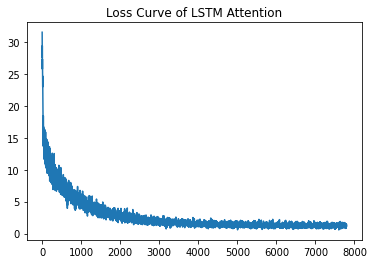

In [29]:
lstm_loss_list = torch.tensor(lstm_loss_list, device = 'cpu')
plt.plot(np.arange(len(lstm_loss_list)), lstm_loss_list)
plt.title('Loss Curve of LSTM Attention')

Test the accuracy of your model. You should be able to get at least 75% accuracy.

In [30]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_lstm(net, train_iter, device):
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]
    
    pred = net.predict(*train_data)

    pred_acc = comp_acc(pred.detach().cpu(), train_data[2].detach().cpu()[:, 1:], train_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()] 
        if pred_wd == 'eos':
          break
        pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].cpu()]))
  
  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  acc_final = torch.cat(acc_list).mean()
  return acc_final
  
seed(1)
batch_size = 32

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
acc_final = evaluate_lstm(lstm_net, train_iter, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
pred:	 ['entrez', '!']

tgt:	 ['unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', "t'en", 'dois', 'une', '.']

tgt:	 ['je', "t'en", 'dois', 'une', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['est-il', 'mort', '?']

tgt:	 ['est-il', 'unk', '?', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'suis', 'unk', '.']

tgt:	 ['je', 'suis', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['demande', 'à', 'qui', 'que', 'ce', 'soit', '!']

tgt:	 ['demande', 'à', 'unk', 'qui', '!', 'eos', 'pad', 'pad', 'pad']

Prediction Acc.: 0.7944


In [31]:
if acc_final > 0.75:
  print("Good!")
  Acc_score = 10
else:
  print("Try again!")
  Acc_score = 0

Good!


In [32]:
# Total 25pt
asgn3_score = LSTM_score + Dot_score + MLP_score + Acc_score
asgn3_score

25

## Discuss and Analysis

In this section, you can experiment with whatever RNN architecture you'd like on this translation dataset and get higher accuracy as well as possible. You may try different architectures, hyperparameters, loss functions or other things. To get full credit, you should test at least one experiment.

Also, you should describe what you did and analyze your experiment results for each experiment. (It can be your thoughts about the limitation of your work/ a possible direction for improvement/ reason why you failed to get high accuracy,..etc)

### Things you might try:
- **Hyperparameter**: Learning rate, Batch size, Vocabulary size, feature dimension, etc.
- **Regularization**: Dropout, Batch normalization, etc
- **Network architecture**: If you want, you can even use other than LSTM. (GRU,..)

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- New Architectures

Feel free to add code blocks and explanation cells below.


In [ ]:
class MYLSTM(nn.Module):
  pass

**Experiment #1** (10 points)

In [33]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, dropout=0, isbidirectional=True):
    super(Encoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the LSTM model
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    # self.enc = LSTM(embedding_dim, hidden_size)
    self.enc = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, dropout=dropout, bidirectional=isbidirectional, num_layers=num_layers)
    self.hidden_size = hidden_size
    
  def forward(self, sources, valid_len):    
    word_embedded = self.embedding(sources) # (N, T, emb_dim)
    N = word_embedded.shape[0]
    h = sources.new_zeros(N, self.hidden_size).float() 
    c = sources.new_zeros(N, self.hidden_size).float() 
    outputs, (h, c) = self.enc((word_embedded, valid_len), (h, c))
    return outputs, (h, c)
  
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, dropout=0, isbidirectional=True):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the LSTM model
    """
    
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    # self.enc = LSTM(embedding_dim+hidden_size, hidden_size)
    self.enc = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, dropout=dropout, bidirectional=isbidirectional, num_layers=num_layers)
    self.att = DotProductAttention()
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size
    
  def forward(self, state, target, valid_len):
    
    enc_outputs, (h, c), src_len = state # h = c = (N, hidden_size) 
    word_embedded = self.embedding(target) # (N, T, emb_dim)
    N, T, emb_dim = word_embedded.shape
    output_list = torch.zeros((N, T, self.hidden_size)).to(device) 
    for t in range(T): #word_embedded[:, t, :] -> (N, emb_dim) 
      x = word_embedded[:, t, :] # (N, emb_dim) -> (N, 1, emb_dim)
      context = self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len) # (N, 1, hidden_size)
      decoder_input = torch.cat([context, x.unsqueeze(1)], dim=2) # (N, 1, emb_dim+hidden_size)
      outputs, (h, c) = self.enc((decoder_input, valid_len), (h, c)) #outputs -> (N, 1, hidden_size)
      output_list[:, t, :] = outputs.squeeze(1) 
    preds = self.output_emb(output_list) # (N, T, vocab_size)
    loss = F.nll_loss(F.log_softmax(preds[:, :T-1].transpose(1,2), dim = 1), target[:, 1:], ignore_index=0, reduction = 'none')
    loss = loss.sum(1).mean()
    preds = preds.argmax(dim=-1)
    return loss, preds
  
  def predict(self, state, target, valid_len):
    pred = None
    
    enc_outputs, (h, c), src_len = state
    word_embedded = self.embedding(target)  #target -> (N, T, vocab_size) -> (N, T, emb_dim)
    # #target -> (N, T), (N, vocab_size), (T, vocab_size)
    (N, T) = target.shape
    inputs = word_embedded[:, :1, :] #<bos> target #(N, 1, emb_dim)
    preds = []
    for t in range(T):
      context = self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len) # (N, 1, hidden_size)
      decoder_input = torch.cat([context, inputs], dim=2) # (N, 1, hidden_size+emb_dim)
      outputs, (h, c) = self.enc((decoder_input, valid_len), (h, c)) #src_len/valid_len -> check
      pred = self.output_emb(outputs) # (N, 1, hidden_size) -> (N, 1, vocab_size)
      preds.append(pred)
      inputs = self.embedding(pred.argmax(dim=-1))
    pred = torch.cat(preds, dim=1).argmax(dim=-1) #(N, T, hidden_size) -> (N, T)
    pred = pred[:, :-1]

    return pred

    

class NMTLSTM(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size):
    super(NMTLSTM, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size)
    
  def forward(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    loss, pred = self.dec((outputs, (h, c), src_len), tgt, tgt_len)
    return loss, pred
  
  def predict(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    pred = self.dec.predict((outputs, (h, c), src_len), tgt, tgt_len)
    return pred


In [34]:
batch_size = 32 # 64, 128
lr = 1e-3 
epochs = 50 # may be early stopping
embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
lstm_net = NMTLSTM(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size, device)
optimizer = torch.optim.Adam(lstm_net.parameters(), lr=lr)
def train_lstm(net, train_iter, lr, epochs, optimizer, device):
  # training
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr) # SGD optimizer
  loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)

      loss_list.append(loss.mean().detach())
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))
  return loss_list
  
lstm_loss_list = train_lstm(lstm_net, train_iter, lr, epochs, optimizer, device)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))


TypeError: ignored

In [ ]:
lstm_loss_list = torch.tensor(lstm_loss_list, device = 'cpu')
plt.plot(np.arange(len(lstm_loss_list)), lstm_loss_list)
plt.title('Loss Curve of LSTM Attention')

In [ ]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_lstm(net, train_iter, device):
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]
    
    pred = net.predict(*train_data)

    pred_acc = comp_acc(pred.detach().cpu(), train_data[2].detach().cpu()[:, 1:], train_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()] 
        if pred_wd == 'eos':
          break
        pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].cpu()]))
  
  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  acc_final = torch.cat(acc_list).mean()
  return acc_final
  
seed(1)
batch_size = 32

vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
acc_final = evaluate_lstm(lstm_net, train_iter, device)